# Introduction

The purpose of this project is to examine crime data in Los Angeles. The data comes from the lacity's website. The dataset reflects incidents of crime in the City of Los Angeles dating back to 2010. The dataset is available via API.

Questions I will be examining
1. Are certain areas more prone to crimes?
2. Are there certain times where more crimes are occuring?
3. Are there subpopulations which are more often targets of crime?
4. What weapons are most often used?

In [2]:
#Import relevant packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sodapy import Socrata
import statsmodels.api as sm
import uszipcode
import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from uszipcode import ZipcodeSearchEngine
from geopy.geocoders import Nominatim
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as sm
from sklearn import metrics

C:\Users\Jai Dave\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Loading and Cleaning the Data

In [3]:
#Load environment variables
un = os.environ.get("usn")
pwd = os.environ.get("pswd")
print(un)

jbdave112@gmail.com


In [4]:
#Load data from La city's database
client = Socrata('data.lacity.org', 'jc1TayctCju6pIwQcAsHYImnr', username=un, password=pwd)
results = client.get("7fvc-faax", limit = 1800000)
crime_df = pd.DataFrame.from_records(results)

In [5]:
#Examine the structure of the data
crime_df.head()

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,...,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd
0,01,Central,821,821,NaN,NaN,NaN,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,SAN PEDRO,2010-11-15T00:00:00.000,...,SIDEWALK,0157,AO,Adult Other,2045,30,H,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400
1,02,Rampart,810,810,NaN,NaN,NaN,"SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W...",NaN,2010-03-01T00:00:00.000,...,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0248,AA,Adult Arrest,0001,11,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400
2,07,Wilshire,626,626,NaN,NaN,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,NaN,2010-11-15T00:00:00.000,...,SINGLE FAMILY DWELLING,0782,AA,Adult Arrest,0030,49,H,F,NaN,NaN
3,07,Wilshire,930,930,NaN,NaN,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,NaN,2010-03-12T00:00:00.000,...,PARK/PLAYGROUND,0724,AA,Adult Arrest,1050,41,B,M,VERBAL THREAT,511
4,07,Wilshire,626,626,NaN,NaN,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,NaN,2010-03-13T00:00:00.000,...,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0735,AA,Adult Arrest,0600,27,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400


In [6]:
#Drop columns with more than 70% of the data missing and coding columns, crm_cd_1 is the same as crm_cd so I will drop that as well
crime_df= crime_df[[column for column in crime_df if crime_df[column].count() / len(crime_df) >= 0.3]]
crime_df = crime_df.drop(['crm_cd_1'], 1)

In [7]:
#Fill Premis Descriptions for which their is already a description assigned to a code, this will only work for rows with a premis code
premise_codes = crime_df.premis_cd.unique()
premise = crime_df.premis_desc.unique()
premise_dict = dict(zip(premise_codes, premise))
crime_df.premis_desc = crime_df.premis_desc.fillna(crime_df.premis_cd.map(premise_dict))
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764551 entries, 0 to 1764550
Data columns (total 21 columns):
area_id           object
area_name         object
crm_cd            object
crm_cd_desc       object
date_occ          object
date_rptd         object
dr_no             object
location          object
location_1        object
mocodes           object
premis_cd         object
premis_desc       object
rpt_dist_no       object
status            object
status_desc       object
time_occ          object
vict_age          object
vict_descent      object
vict_sex          object
weapon_desc       object
weapon_used_cd    object
dtypes: object(21)
memory usage: 282.7+ MB


In [8]:
#Remove rows with an na value as the location
crime_df = crime_df[pd.notnull(crime_df['location_1'])]

In [9]:
#Create columns containing longitude and latitude data
def get_long(coordinates):
    return coordinates['coordinates'][0]
def get_lat(coordinates):
    return coordinates['coordinates'][1]
crime_df['longitude'] = crime_df['location_1'].apply(get_long)
crime_df['latitude'] =crime_df['location_1'].apply(get_lat)

In [10]:
#Drop rows with (0,0) location data
crime_df = crime_df[crime_df.longitude != 0]

In [11]:
#Create a column that contains the zipcode where the crime occurred
search = ZipcodeSearchEngine()
def get_zip(latitude, longitude):
    res = search.by_coordinate(latitude, longitude, radius=30, returns=1)
    return res[0]['Zipcode']
crime_df['zipcode'] = crime_df.apply(lambda x: get_zip(x['latitude'], x['longitude']), axis=1)

## Crime Over Time

In [12]:
#Change time format
crime_df['time'] = crime_df['time_occ'].str[0:2] + ':' + crime_df['time_occ'].str[2:4]

In [13]:
#Combine time and date columns
crime_df['dt'] = crime_df['date_occ'].str[0:10] + ' ' + crime_df['time']

Text(0.5,0,'Year')

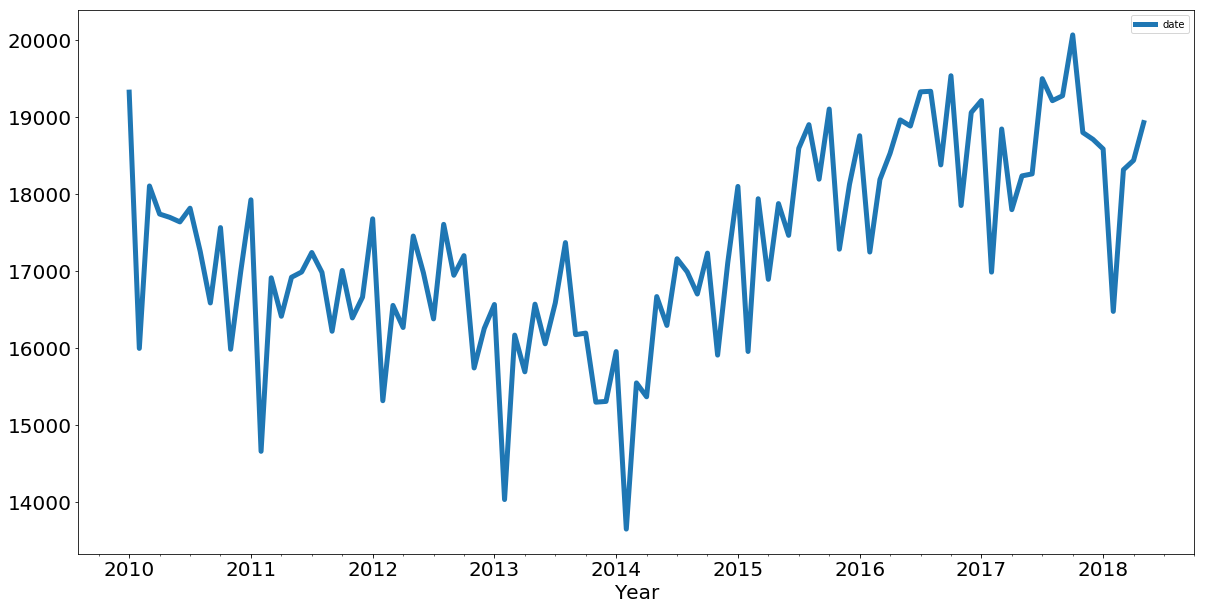

In [14]:
#Create datetime
time_format = '%Y-%m-%d %H:%M'
crime_df['date'] = pd.to_datetime(crime_df['dt'], format = time_format)

#Create a dataframe with the date column created above
time_df = crime_df.loc[:, ['date']]

#Exclude latest month as the month is not over yet
time_df = time_df.loc[~(time_df['date'].dt.month.eq(6) & time_df['date'].dt.year.eq(2018))]

#Reindex with the date and plot data by month
time_df.index = time_df['date']
time_df.resample('M').count().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

In [15]:
#Group time by hour
crime_df['hour'] = [r.hour for r in crime_df.date]

## Crimes and Weapons Used

In [16]:
#The ten most frequent crimes in LA since 2010
crime_df.groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
BATTERY - SIMPLE ASSAULT                                        160370
BURGLARY FROM VEHICLE                                           135071
VEHICLE - STOLEN                                                135045
BURGLARY                                                        126020
THEFT PLAIN - PETTY ($950 & UNDER)                              124792
THEFT OF IDENTITY                                               109815
INTIMATE PARTNER - SIMPLE ASSAULT                                95082
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114     87822
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                         77994
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                   75487
Name: crm_cd, dtype: int64

To identify what weapons are frequently used, I will isolate the crime_cd_desc "Assault with deadly weapon, aggravated assault" and get counts for the different weapons used. Crime code 230 corresponds to Assault with a deadly weapon, aggravated assault.

In [17]:
#Weapons used frequently for Assaults
weapons = crime_df[crime_df['crm_cd']=='230']

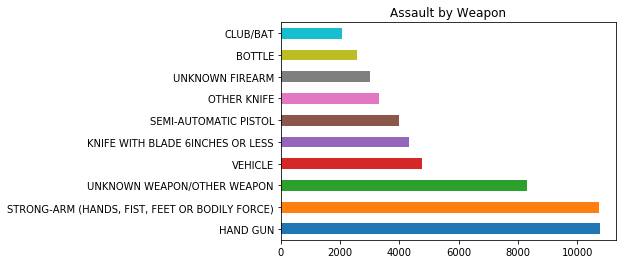

In [18]:
#Plot most frequently used weapons for assaults
ax = weapons['weapon_desc'].value_counts()[:10].plot(kind='barh', title = 'Assault by Weapon')

From the plot above one can see that hand guns are the most used weapon in crimes coded as "Assault with deadly weapon, aggravated assault". Los Angeles has an anonomyous gun buy back program. Perhaps by creating similar programs or increasing awareness of the program would reduce the number of assaults with the use of a gun.

## Crimes by Location

{'01': 'Central', '02': 'Rampart', '07': 'Wilshire', '08': 'West LA', '20': 'Olympic', '03': 'Southwest', '09': 'Van Nuys', '16': 'Foothill', '18': 'Southeast', '21': 'Topanga', '10': 'West Valley', '12': '77th Street', '13': 'Newton', '15': 'N Hollywood', '04': 'Hollenbeck', '05': 'Harbor', '06': 'Hollywood', '17': 'Devonshire', '11': 'Northeast', '14': 'Pacific', '19': 'Mission'}


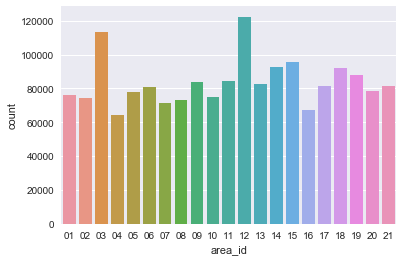

In [19]:
#Get Distinct area ids and area names
area_ids = crime_df.area_id.unique()
area_names = crime_df.area_name.unique()

#Create dictionay with area id as the key and area name as the value
area_dict = dict(zip(area_ids, area_names))
print(area_dict)

#Plot the count of crimes in each area
sns.set(style="darkgrid")
ax = sns.countplot(x='area_id', data = crime_df)

Areas with significantly more crimes are "77th street" and the "Southwest region". From this graph we can not tell if this is a result of those areas containing a larger share of LA's population. To test this I will use a proportion test using data taken from the LAPD's website. According to the website the 77th street area has a population of approximately 175,000. According to the United States Census Bureau Los Angles has a population of approxiately 3,976,000. To test if the 77th street area is more prone to crime I will do a proportion z test. http://www.lapdonline.org/77th_street_community_police_station/content_basic_view/1573

In [21]:
from statsmodels.stats.proportion import proportions_ztest

In [22]:
#Calculate the total amount of crimes in the dataset and the total count of crimes in 77th street area
total_count = crime_df.crm_cd.count()
Area_77 = crime_df[crime_df['area_id']=='12']['crm_cd']
count_77 = Area_77.count()

"""Use a proportion test to check if the proportion of crimes occuring in the 77th street are significantly different than 
the proportion of the population that lives there"""
z_score, p_value = proportions_ztest([count_77, 175000], [total_count, 3976000])
print(z_score, p_value)

127.66535178432935 0.0


From this test we can see that the proportion of crimes that occur in 77th street community is significantly different to the proportion of individuals who live there compared to LA as a whole.

In [23]:
#Obtain the ten most frequent crimes in the 77th street area
crime_df[crime_df['area_id']=='12'].groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
BATTERY - SIMPLE ASSAULT                          13218
VEHICLE - STOLEN                                  10948
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT     9880
ROBBERY                                            8686
BURGLARY                                           8481
INTIMATE PARTNER - SIMPLE ASSAULT                  8053
BURGLARY FROM VEHICLE                              6440
VANDALISM - MISDEAMEANOR ($399 OR UNDER)           5918
THEFT PLAIN - PETTY ($950 & UNDER)                 5805
THEFT OF IDENTITY                                  5577
Name: crm_cd, dtype: int64

In the 77th street area Assault with a deadly weapon is the third most common crime. Below I will test if the proportion of assaults in this area are significantly different than the proportions of the entire dataset.

In [24]:
#Filter dataset for assaults in the 77th street area
Area_77_Assaults = crime_df[(crime_df['crm_cd']=='230') & (crime_df['area_id'] == '12')]['crm_cd']

"""Obtain the count of the total number of crimes occuring in the 77th st area, the number of assaults in the 77th st area,
and the number of assaults that occur across all areas"""
Total_Area_count = crime_df[crime_df['area_id']=='12']['crm_cd'].count()
Area_Assault_count = Area_77_Assaults.count()
Total_Assault_count = crime_df[crime_df['crm_cd']=='230']['crm_cd'].count()

#Use a proportion test to determine if assaults are a larger proportion of the total crimes in the 77th St. Area
z_score, p_value = proportions_ztest([Area_Assault_count, Total_Assault_count], [Total_Area_count, total_count])
print(z_score, p_value)

61.338112675024625 0.0


From the above proportion test we can see that Assaults are more likely to occur in the 77th Street Area than in Los Angeles as a whole.

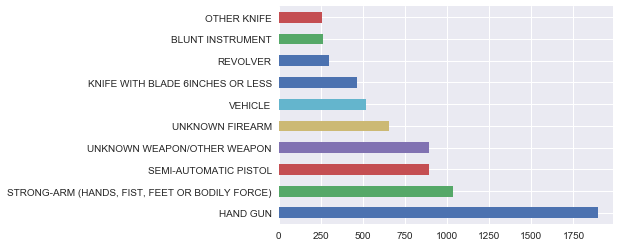

In [28]:
#Weapons most frequently used for assaults in the 77th area
area_weapons = crime_df[(crime_df['crm_cd']=='230') & (crime_df['area_id'] == '12')]
area_weapons.groupby('weapon_desc').crm_cd.count().sort_values(ascending=False).head(10)
ax = area_weapons['weapon_desc'].value_counts()[:10].plot(kind='barh')

From the graph above we can see that the number of assaults with the use of hand guns far far surpasses all other types of assaults. Focusing on getting guns off the streets targeted at this area may help lower the number of assaults with the use of a firearm.

## When Crimes Occur

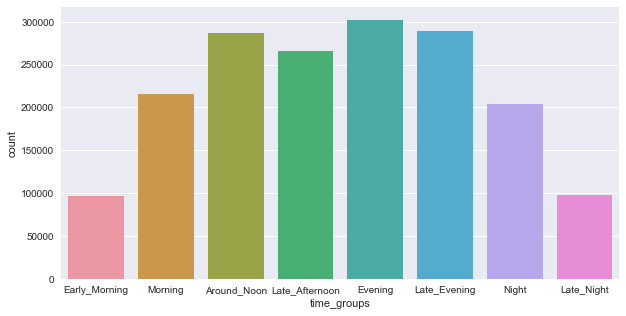

In [29]:
#Put the time crimes occur into buckets
crime_df['time'] = pd.to_numeric(crime_df['time_occ'])
def label_time(row):
    if 500 <= row < 800:
        return 'Early_Morning'
    elif 800 <= row < 1100:
        return 'Morning'
    elif 1100 <= row < 1400:
        return 'Around_Noon'
    elif 1400 <= row < 1700:
        return 'Late_Afternoon'
    elif 1700 <= row < 2000:
        return 'Evening'
    elif 2000 <= row < 2300:
        return 'Late_Evening'
    elif 2300 <= row <= 2400 or 0 <= row < 200:
        return 'Night'
    elif 200 <= row < 500:
        return 'Late_Night'
    else:
        return 'Other'

#Create new column based on function above
crime_df['time_groups'] = crime_df['time'].apply(label_time)
plt.figure(figsize=(10,5))
axis = sns.countplot(x = 'time_groups', data = crime_df, order = ['Early_Morning', 'Morning', 'Around_Noon', 'Late_Afternoon', 'Evening', 'Late_Evening', 'Night', 'Late_Night'])

In [30]:
#Get day of the week
def day_convert(date):
    return date.strftime("%A")

#Create column that contains the day of each crime
crime_df['day'] = crime_df['date'].apply(day_convert)

In [31]:
#Create larger bins to see if more crimes are occuring at a certain time of day for specific days
def label_time(row):
    if 400 <= row < 1200:
        return 'Morning'
    elif 1200 <= row < 2000:
        return 'Afternoon'
    elif 2000 <= row < 2400 or 0<=row < 400:
        return 'Night'
    
#Create a new column based on formula above
crime_df['time_groups_2'] = crime_df['time'].apply(label_time)

Text(0,0.5,'Crime Count')

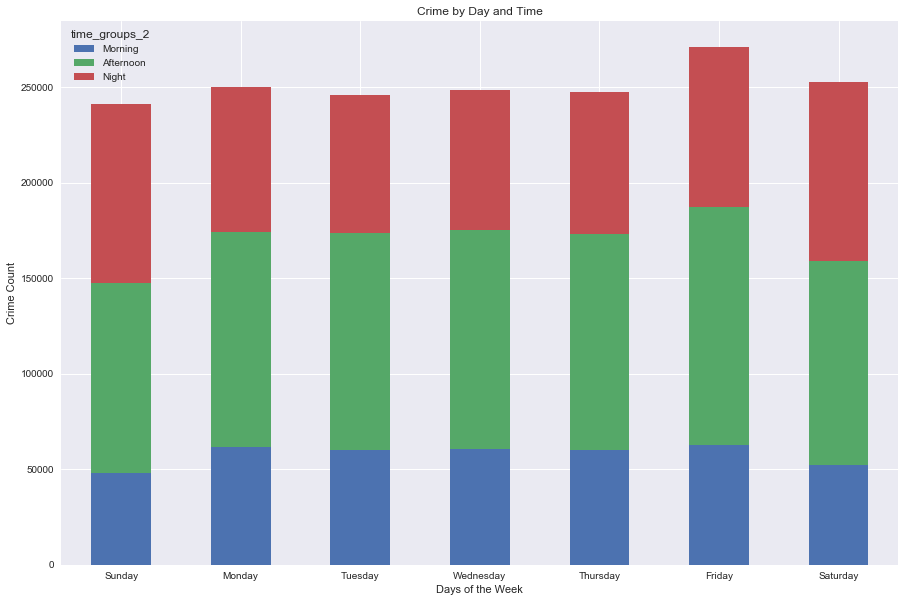

In [32]:
counts = crime_df.groupby(['day', 'time_groups_2'])['crm_cd'].count().unstack('time_groups_2').fillna(0)
m = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
counts = counts.reindex(m)
ax = counts[['Morning', 'Afternoon', 'Night']].plot(kind='bar', stacked = True, figsize=(15,10), title = 'Crime by Day and Time', rot=0)
ax.set_xlabel("Days of the Week")
ax.set_ylabel("Crime Count")

It appears that crimes are evenly spread between days with a small spike on Fridays. Fridays appear to have more crimes occuring in the afternoon. The below test exams if the increase in crime on Fridays is significant.

In [33]:
#Proportion test to see if more crimes occur on Fridays
Friday_count = crime_df[crime_df['day']=='Friday']['crm_cd'].count()
z_score, p_value = proportions_ztest([Friday_count, (total_count/7)], [total_count, total_count])
print(z_score, p_value)

30.04267854681535 2.7211811528343043e-198


From the test above we can see that Friday has a statistically significant increase in crimes over other days. It appears the difference is in the afternoon. Below I will examine what crimes have the largest spikes on Friday afternoon.

In [34]:
#The most common crimes occuring on Friday afternoons
Friday_Afternoon = crime_df[(crime_df['day']=='Friday') & (crime_df['time_groups_2'] == 'Afternoon')]
Friday_Afternoon.groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
THEFT PLAIN - PETTY ($950 & UNDER)                              10906
BATTERY - SIMPLE ASSAULT                                        10632
BURGLARY                                                         9927
THEFT OF IDENTITY                                                9766
VEHICLE - STOLEN                                                 8398
BURGLARY FROM VEHICLE                                            8148
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114     5715
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036     5565
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)                  5209
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                         5045
Name: crm_cd, dtype: int64

Comparing the most common crimes on Friday afternoons to the most common crimes in general it apperas that different types of theft are more common on Friday afternoons. This could possibly be because individuals have debts that are due at the end of the workweek and out of desperation turn to crime.

## Victim Demographics

In [35]:
#Convert age to numerics and calculate the mean and median
crime_df['age'] = pd.to_numeric(crime_df['vict_age'])
age_mean = crime_df['age'].mean()
age_median = crime_df['age'].median()
print(age_mean)
print(age_median)

35.98612865199046
34.0


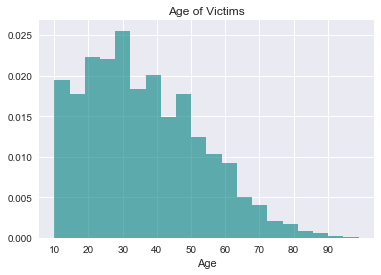

In [36]:
#Examine the distribution of age for victims
plt.xlabel('Age')
plt.title('Age of Victims')
plt.xticks(range(0, 100, 10))
plt.hist(crime_df['age'].dropna(), bins=20, density = True, stacked = True, color = 'teal', alpha = .6)
plt.show()

From this histogram we can see that the portion of the population that are the most victimized are those in their late 20s and early 30s and the risk of victimization appears to drop as individuals get older. 

In [37]:
#Calculate the amount of crimes by victim descent and victim sex
counts = crime_df.groupby(['vict_descent', 'vict_sex'])['crm_cd'].count().sort_values(ascending=False).head(8).unstack('vict_sex').fillna(0)
print(counts)

vict_sex             F         M
vict_descent                    
B             163497.0  117738.0
H             308082.0  299378.0
O              58255.0  111693.0
W             186928.0  244212.0


[Text(0,0,'Black'), Text(0,0,'Latino'), Text(0,0,'Other'), Text(0,0,'White')]

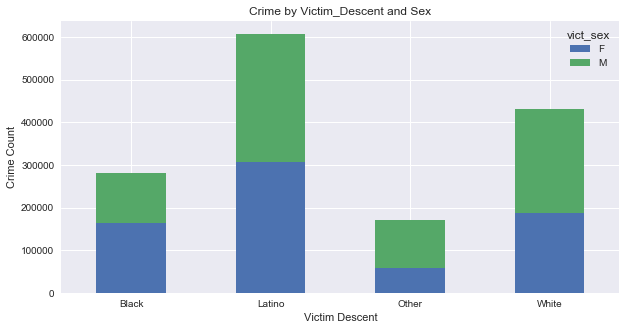

In [38]:
ax = counts[['F', 'M']].plot(kind='bar', stacked = True,figsize=(10,5), title = 'Crime by Victim_Descent and Sex', rot=0)
ax.set_xlabel('Victim Descent')
ax.set_ylabel('Crime Count')
ax.set_xticklabels( ('Black', 'Latino','Other', 'White') )

Victims are more likely to be hispanic, white, or black. 
Among black victims females outnumber males. This could possibly be because black victims are less likely to report a crime. This leads me to believe that the number of crimes against the black population is greater than what the data shows.
Among white victims it appears that white males are more likely to be victim of crimes than males.

In [39]:
#Crimes most expiereince by homeless individuals. 1218 refers to an mocode that indicates a homeless victim
crime_df[crime_df['mocodes'].str.contains('1218', na=False)].groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head()

crm_cd_desc
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    2897
BATTERY - SIMPLE ASSAULT                          2234
ROBBERY                                           1387
THEFT PLAIN - PETTY ($950 & UNDER)                1110
INTIMATE PARTNER - SIMPLE ASSAULT                 1039
Name: crm_cd, dtype: int64

Three of the five most common crimes experienced by homeless indiviuals is assault suggesting  that a larger proportion of crimes against homeless individuals are assaults

Preproccess Data for predicitve modeling

Next I will examine the possible relationship between zipcode and other variables. It is my hope that we can predict the zipcode a crime will occur based on other features

In [40]:
#Encode Dependent Variable zipcode as numbers and store in dataframe
number = LabelEncoder()
crime_df['target'] = number.fit_transform(crime_df['zipcode'].astype('str'))
label = crime_df['target']

In [41]:
#There are many different crime types. To make the model manageable I will group less common crime types
not_top = crime_df.groupby('crm_cd').crm_cd.count().sort_values(ascending=False).index[10:]
dfnew  = crime_df.replace(not_top, 'Other')

In [42]:
#Group time by hour
crime_df['month'] = [r.month for r in crime_df.date]

In [115]:
"""Create features dataframe which includes dummy variables for categorical variables: day of the week, time of the day,type of
 crime and district"""
features = pd.get_dummies(crime_df.area_name, prefix = 'area').iloc[:, 1:]
days_dm = pd.get_dummies(crime_df.day, prefix = 'day').iloc[:, 1:]
hour_dm = pd.get_dummies(crime_df.time_groups, prefix = 'time').iloc[:, 1:]
crm_dm = pd.get_dummies(crime_df.crm_cd, prefix = 'crm_cd').iloc[:, 1:]
features = pd.concat([features, hour_dm, days_dm, crm_dm], axis = 1)

In [116]:
#Split dataset into train and test sets, create RandomForestClassifier, and train model
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25)

#Create classifier
clf = RandomForestClassifier(n_estimators = 10)

#Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [117]:
#Calculate how often the classifier is correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2942340041473469


Test for Multicollinearity 

In [56]:
#Create new model using month instead of crime type
features2 = pd.get_dummies(crime_df.area_name, prefix = 'area').iloc[:, 1:]
days_dm = pd.get_dummies(crime_df.day, prefix = 'day').iloc[:, 1:]
time_dm = pd.get_dummies(crime_df.time_groups, prefix = 'time_groups').iloc[:, 1:]
month_dm = pd.get_dummies(crime_df.month, prefix='month').iloc[:, 1:]
features2 = pd.concat([features2, time_dm, days_dm, month_dm], axis = 1)

In [58]:
#Split dataset into train and test sets, create RandomForestClassifier, and train model
X_train, X_test, y_train, y_test = train_test_split(features2, label, test_size=0.25)

#Create classifier
clf = RandomForestClassifier(n_estimators = 10)

#Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [59]:
#Calculate how often the classifier is correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.29009348602489776


Next I will examine a subset of the dataset. Here I will look specifically at one district: 77th Street

In [61]:
#Create dataframe
df_77 = crime_df[crime_df['area_id']=='12']

In [135]:
#Create features dataframe which includes dummy variables for categorical variables: time, month, and day
label2 = df_77['target']
features3 = pd.get_dummies(df_77.day, prefix = 'day').iloc[:, 1:]
hour_dm = pd.get_dummies(df_77.time_groups, prefix = 'hour').iloc[:, 1:]
month_dm = pd.get_dummies(df_77.month, prefix='month').iloc[:, 1:]
features3 = pd.concat([features3, hour_dm, month_dm], axis = 1)

In [136]:
#Split dataset into train and test sets, create RandomForestClassifier, and train model
X_train, X_test, y_train, y_test = train_test_split(features3, label2, test_size=0.25)

#Create classifier
clf = RandomForestClassifier(n_estimators = 10)

#Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [137]:
#How often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3227029146516795


In [138]:
#Rank which features are the most important to the model
feature_imp = pd.Series(clf.feature_importances_,index=features3.columns.values).sort_values(ascending=False)
feature_imp

day_Tuesday            0.072615
day_Wednesday          0.064183
day_Sunday             0.057166
day_Monday             0.056881
day_Thursday           0.056750
day_Saturday           0.047900
hour_Evening           0.045136
month_2                0.044101
month_5                0.042886
month_11               0.042849
month_7                0.042725
month_3                0.038746
month_6                0.035510
month_8                0.035462
hour_Morning           0.035354
month_4                0.035053
hour_Late_Evening      0.032563
month_9                0.032356
month_10               0.032289
hour_Early_Morning     0.031882
month_12               0.029988
hour_Late_Night        0.029688
hour_Night             0.029397
hour_Late_Afternoon    0.028518
dtype: float64

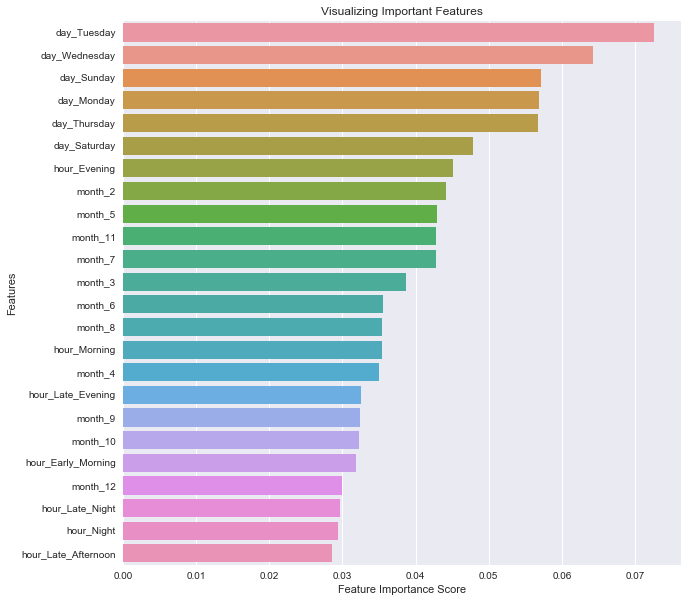

In [140]:
# Creating a bar plot of the top 50 features for the model
plt.figure(figsize=(10,10))
ax = sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

The best model I was able to create had an accuracy rate of 32%. This particular model looked at the 77th street district specifically. This model used the variables: day of the week, month, and time of day.